# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda

Vamos trabalhar com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [2]:
# Importar bibliotecas padrão (nenhuma neste caso)

# Importar bibliotecas de terceiros
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Importar pacotes específicos de bibliotecas ou funções
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import r2_score

In [4]:
#Carregar base de dados
renda_raw = pd.read_csv('m13_income_prediction.csv')
renda_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   index                  15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          12466 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  mau                    15000 non-null  bool   
 15  re

In [6]:
#Data Wrangling - Structuring
renda_raw['data_ref'] = pd.to_datetime(renda_raw['data_ref'])
renda_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             15000 non-null  int64         
 1   data_ref               15000 non-null  datetime64[ns]
 2   index                  15000 non-null  int64         
 3   sexo                   15000 non-null  object        
 4   posse_de_veiculo       15000 non-null  bool          
 5   posse_de_imovel        15000 non-null  bool          
 6   qtd_filhos             15000 non-null  int64         
 7   tipo_renda             15000 non-null  object        
 8   educacao               15000 non-null  object        
 9   estado_civil           15000 non-null  object        
 10  tipo_residencia        15000 non-null  object        
 11  idade                  15000 non-null  int64         
 12  tempo_emprego          12466 non-null  float64       
 13  q

In [12]:
#Data Wrangling - Cleaning
renda = renda_raw.dropna().copy()
renda.describe()

,Unnamed: 0,data_ref,index,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
count,12466.000000,12466,12466.000000,12466.000000,12466.000000,12466.000000,12466.000000,12466.000000
mean,7513.599711,2015-08-01 17:46:11.763195904,8383.234077,0.517327,40.701989,7.750462,2.313653,4850.045256
min,0.000000,2015-01-01 00:00:00,0.000000,0.000000,22.000000,0.191781,1.000000,159.900000
25%,3753.500000,2015-04-01 00:00:00,4264.250000,0.000000,33.000000,3.016438,2.000000,2026.390000
50%,7542.500000,2015-08-01 00:00:00,8458.500000,0.000000,40.000000,6.016438,2.000000,3422.440000
75%,11284.500000,2015-12-01 00:00:00,12540.750000,1.000000,48.000000,10.183562,3.000000,5916.970000
max,14999.000000,2016-03-01 00:00:00,16649.000000,14.000000,67.000000,42.906849,15.000000,89918.040000
std,4340.440720,NaN,4792.750858,0.804358,9.362546,6.780216,0.955471,4873.182512


1. Ajuste um modelo para prever log(renda) considerando todas as covariáveis disponíveis.
    - Utilizando os recursos do Patsy, coloque as variáveis qualitativas como *dummies*.
    - Mantenha sempre a categoria mais frequente como casela de referência
    - Avalie os parâmetros e veja se parecem fazer sentido prático.

2. Remova a variável menos significante e analise:
    - Observe os indicadores que vimos, e avalie se o modelo melhorou ou piorou na sua opinião.
    - Observe os parâmetros e veja se algum se alterou muito.

3. Siga removendo as variáveis menos significantes, sempre que o *p-value* for menor que 5%. Compare o modelo final com o inicial. Observe os indicadores e conclua se o modelo parece melhor. 
    

In [54]:
# 01 - Ajuste um modelo para prever log(renda) considerando todas as covariáveis disponíveis.
mod_1 = smf.ols('''np.log(renda + 0.1) ~ sexo 
                                            + posse_de_veiculo 
                                            + posse_de_imovel 
                                            + qtd_filhos 
                                            + tipo_renda 
                                            + educacao 
                                            + estado_civil 
                                            + tipo_residencia 
                                            + idade 
                                            + tempo_emprego 
                                            + qt_pessoas_residencia 
                                            + mau''', data=renda).fit()
mod_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log(renda + 0.1)   R-squared:                       0.242
Model:                             OLS   Adj. R-squared:                  0.240
Method:                  Least Squares   F-statistic:                     158.7
Date:                 Sun, 15 Sep 2024   Prob (F-statistic):               0.00
Time:                         13:00:31   Log-Likelihood:                -13203.
No. Observations:                12466   AIC:                         2.646e+04
Df Residuals:                    12440   BIC:                         2.665e+04
Df Model:                           25                                         
Covariance Type:             nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            7.2007      0.272     26.485      0.000       6.668       7.734
sexo[T.M]                            0.4815      0.014     33.681      0.000       0.453       0.509
posse_de_veiculo[T.True]            -0.0014      0.014     -0.104      0.917      -0.028       0.026
posse_de_imovel[T.True]              0.0847      0.014      6.260      0.000       0.058       0.111
tipo_renda[T.Bolsista]              -0.0499      0.350     -0.143      0.887      -0.735       0.636
tipo_renda[T.Empresário]             0.1787      0.015     12.217      0.000       0.150       0.207
tipo_renda[T.Pensionista]            0.4099      0.237      1.732      0.083      -0.054       0.874
tipo_renda[T.Servidor público]       0.0949      0.021      4.482      0.000       0.053       0.136
educacao[T.Pós graduação]            0.5496      0.175      3.133      0.002       0.206       0.893
educacao[T.Secundário]               0.0166      0.071      0.233      0.816      -0.123       0.156
educacao[T.Superior completo]        0.1134      0.071      1.590      0.112      -0.026       0.253
educacao[T.Superior incompleto]     -0.0090      0.076     -0.117      0.907      -0.159       0.141
estado_civil[T.Separado]            -0.0395      0.131     -0.302      0.763      -0.296       0.217
estado_civil[T.Solteiro]             0.0213      0.129      0.166      0.868      -0.231       0.273
estado_civil[T.União]               -0.0256      0.023     -1.098      0.272      -0.071       0.020
estado_civil[T.Viúvo]               -0.0377      0.134     -0.280      0.779      -0.301       0.226
tipo_residencia[T.Casa]              0.0146      0.053      0.274      0.784      -0.090       0.119
tipo_residencia[T.Com os pais]      -0.0578      0.060     -0.967      0.334      -0.175       0.059
tipo_residencia[T.Comunitário]       0.0571      0.103      0.555      0.579      -0.145       0.259
tipo_residencia[T.Estúdio]          -0.1093      0.089     -1.231      0.218      -0.283       0.065
tipo_residencia[T.Governamental]    -0.0567      0.064     -0.880      0.379      -0.183       0.070
mau[T.True]                         -0.0323      0.042     -0.778      0.437      -0.114       0.049
qtd_filhos                           0.0047      0.128      0.037      0.971      -0.247       0.256
idade                                0.0052      0.001      6.628      0.000       0.004       0.007
tempo_emprego                        0.0482      0.001     48.349      0.000       0.046       0.050
qt_pessoas_residencia                0.0114      0.128      0.089      0.929      -0.239       0.262
==============================================================================
Omnibus:                        1.200   Durbin-Watson:          

In [48]:
mod_2 = smf.ols('''np.log(renda + 0.1) ~ sexo 
                                            + posse_de_veiculo 
                                            + posse_de_imovel 
                                            + C(qtd_filhos) 
                                            + tipo_renda 
                                            + educacao 
                                            + estado_civil 
                                            + tipo_residencia 
                                            + idade 
                                            + tempo_emprego 
                                            + C(qt_pessoas_residencia) 
                                            + mau''', data=renda).fit()
mod_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log(renda + 0.1)   R-squared:                       0.243
Model:                             OLS   Adj. R-squared:                  0.241
Method:                  Least Squares   F-statistic:                     113.9
Date:                 Sun, 15 Sep 2024   Prob (F-statistic):               0.00
Time:                         12:29:28   Log-Likelihood:                -13194.
No. Observations:                12466   AIC:                         2.646e+04
Df Residuals:                    12430   BIC:                         2.673e+04
Df Model:                           35                                         
Covariance Type:             nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            7.2115      0.159     45.409      0.000       6.900       7.523
sexo[T.M]                            0.4809      0.014     33.595      0.000       0.453       0.509
posse_de_veiculo[T.True]            -0.0016      0.014     -0.120      0.905      -0.029       0.025
posse_de_imovel[T.True]              0.0859      0.014      6.338      0.000       0.059       0.113
C(qtd_filhos)[T.1]                  -0.0389      0.131     -0.297      0.766      -0.295       0.217
C(qtd_filhos)[T.2]                   0.0986      0.267      0.369      0.712      -0.426       0.623
C(qtd_filhos)[T.3]                  -0.4639      0.471     -0.984      0.325      -1.388       0.460
C(qtd_filhos)[T.4]                  -0.1604      0.429     -0.374      0.709      -1.001       0.681
C(qtd_filhos)[T.5]                  -0.0292      0.393     -0.074      0.941      -0.800       0.742
C(qtd_filhos)[T.7]                  -0.4749      0.255     -1.860      0.063      -0.975       0.026
C(qtd_filhos)[T.14]                  0.0666      0.175      0.380      0.704      -0.277       0.410
tipo_renda[T.Bolsista]              -0.0497      0.350     -0.142      0.887      -0.735       0.636
tipo_renda[T.Empresário]             0.1791      0.015     12.241      0.000       0.150       0.208
tipo_renda[T.Pensionista]            0.4107      0.237      1.736      0.083      -0.053       0.875
tipo_renda[T.Servidor público]       0.0936      0.021      4.417      0.000       0.052       0.135
educacao[T.Pós graduação]            0.5709      0.176      3.250      0.001       0.227       0.915
educacao[T.Secundário]               0.0213      0.071      0.300      0.764      -0.118       0.161
educacao[T.Superior completo]        0.1177      0.071      1.650      0.099      -0.022       0.257
educacao[T.Superior incompleto]     -0.0064      0.076     -0.084      0.933      -0.156       0.143
estado_civil[T.Separado]            -0.0338      0.131     -0.258      0.797      -0.291       0.223
estado_civil[T.Solteiro]             0.0258      0.129      0.200      0.841      -0.227       0.279
estado_civil[T.União]               -0.0243      0.023     -1.042      0.298      -0.070       0.021
estado_civil[T.Viúvo]               -0.0343      0.135     -0.254      0.799      -0.299       0.230
tipo_residencia[T.Casa]              0.0152      0.053      0.286      0.775      -0.089       0.120
tipo_residencia[T.Com os pais]      -0.0579      0.060     -0.969      0.333      -0.175       0.059
tipo_residencia[T.Comunitário]       0.0694      0.103      0.671      0.502      -0.133       0.272
tipo_residencia[T.Estúdio]          -0.1072      0.089     -1.206      0.228      -0.281       0.067
tipo_residencia[T.Governamental]    -0.043

In [22]:
# Calcular frequência dos dados:
# Selecionar as colunas do tipo object
colunas_obj = renda.select_dtypes(include=['object']).columns

# Exibir as frequências de cada categoria em cada coluna do tipo object
for col in colunas_obj:
    print(f"Frequências da coluna '{col}':")
    print(renda[col].value_counts())
    print("\n")

Frequências da coluna 'sexo':
sexo
F    7991
M    4475
Name: count, dtype: int64


Frequências da coluna 'tipo_renda':
tipo_renda
Assalariado         7826
Empresário          3311
Servidor público    1316
Pensionista            9
Bolsista               4
Name: count, dtype: int64


Frequências da coluna 'educacao':
educacao
Secundário             7161
Superior completo      4618
Superior incompleto     569
Primário                 99
Pós graduação            19
Name: count, dtype: int64


Frequências da coluna 'estado_civil':
estado_civil
Casado      8896
Solteiro    1522
União       1027
Separado     705
Viúvo        316
Name: count, dtype: int64


Frequências da coluna 'tipo_residencia':
tipo_residencia
Casa             11128
Com os pais        636
Governamental      366
Aluguel            176
Estúdio             97
Comunitário         63
Name: count, dtype: int64




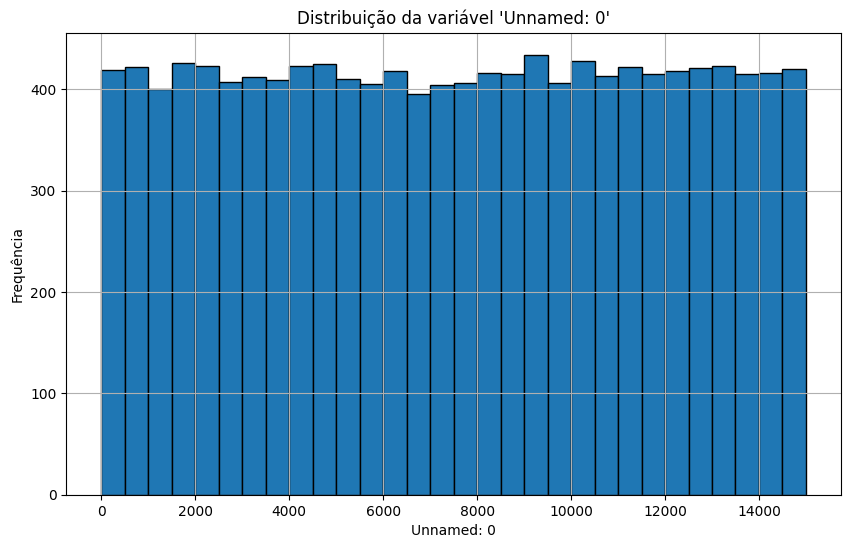

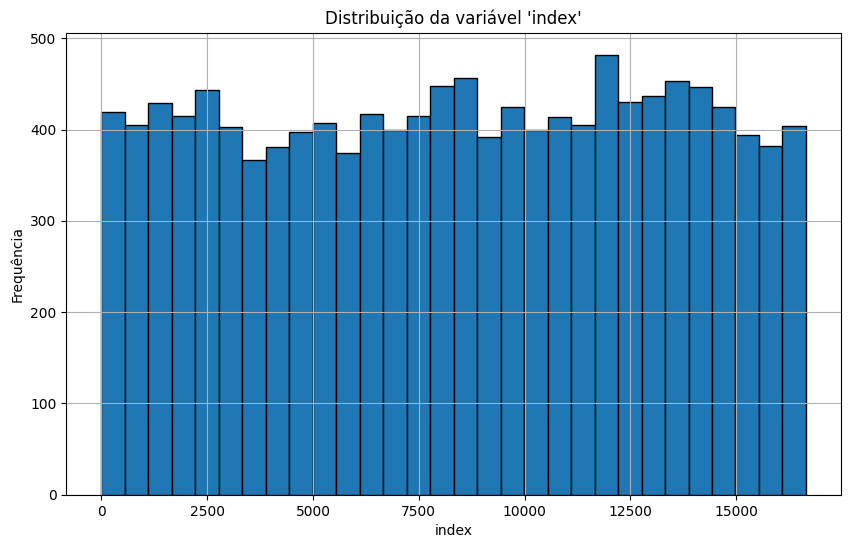

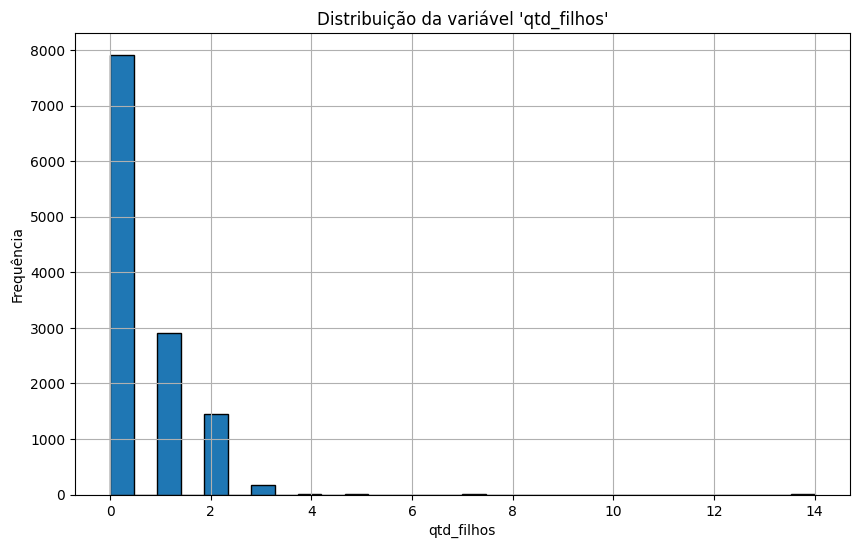

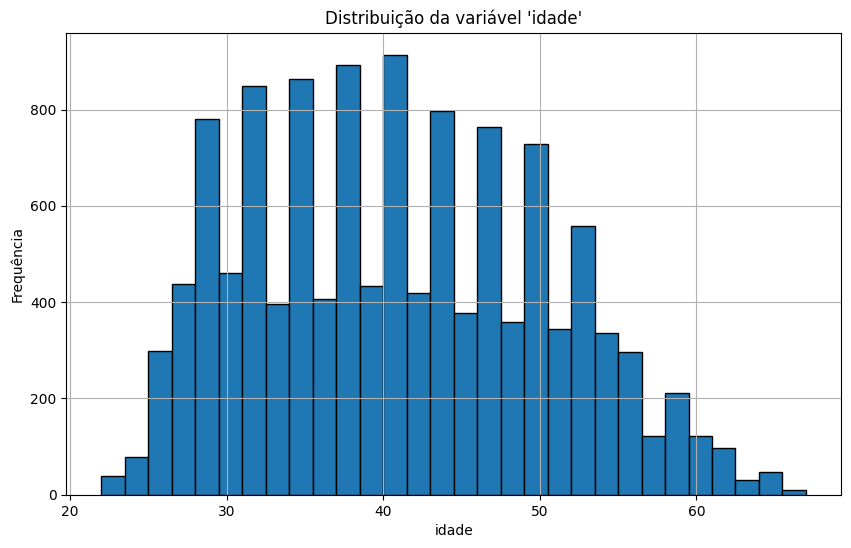

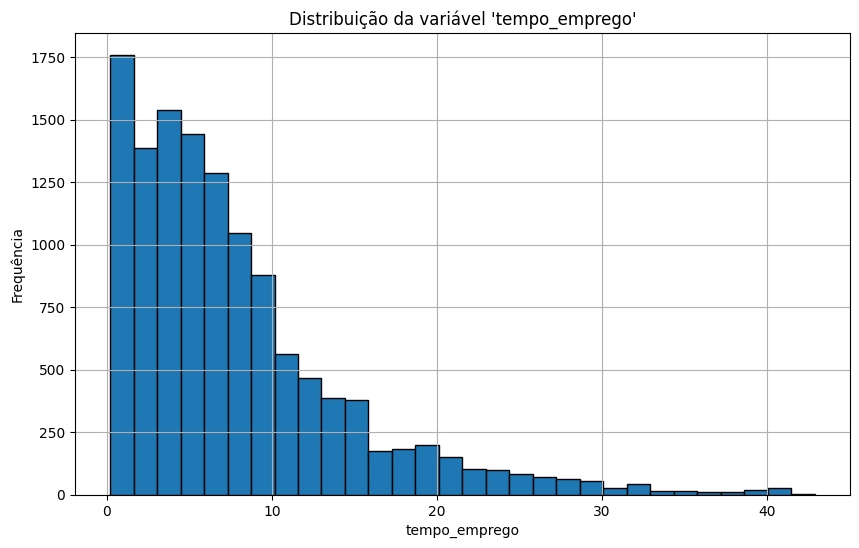

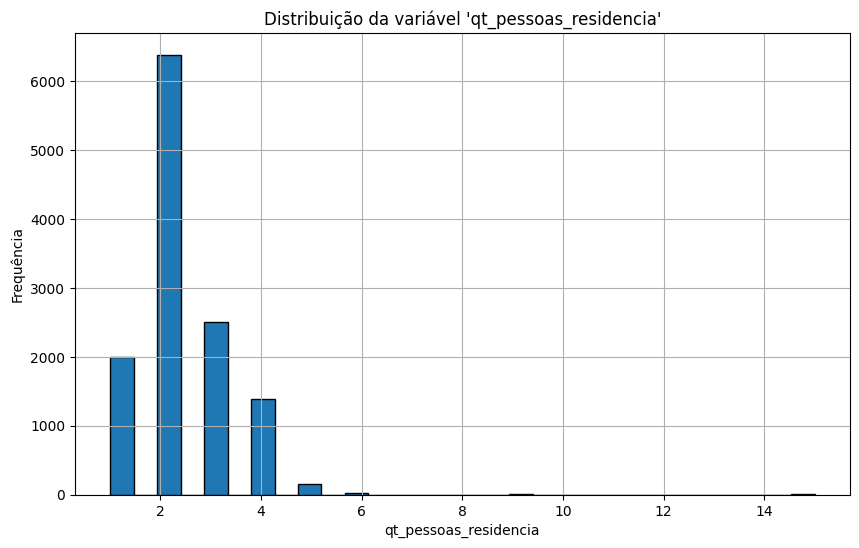

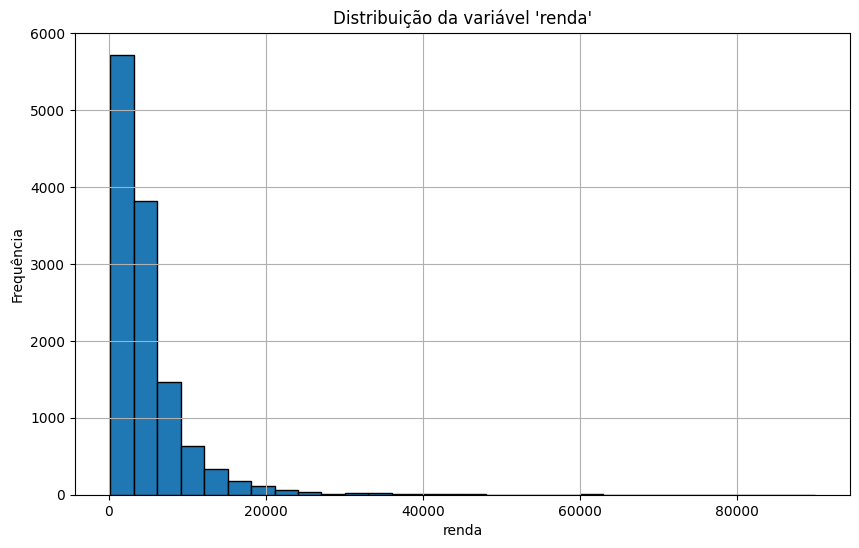

In [24]:
# Selecionar as colunas numéricas
colunas_num = renda.select_dtypes(include=['int64', 'float64']).columns

# Criar gráficos de barras para cada variável numérica
for col in colunas_num:
    plt.figure(figsize=(10, 6))
    renda[col].plot(kind='hist', bins=30, edgecolor='black')
    plt.title(f"Distribuição da variável '{col}'")
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.grid(True)
    plt.show()

In [56]:
mod_3 = smf.ols('''np.log(renda + 0.1) ~ sexo 
                                            + posse_de_veiculo 
                                            + posse_de_imovel 
                                            + C(qtd_filhos, Treatment(1)) 
                                            + tipo_renda 
                                            + educacao 
                                            + estado_civil 
                                            + tipo_residencia 
                                            + idade 
                                            + tempo_emprego
                                            + C(qt_pessoas_residencia, Treatment(2)) 
                                            + mau''', data=renda).fit()
mod_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log(renda + 0.1)   R-squared:                       0.243
Model:                             OLS   Adj. R-squared:                  0.241
Method:                  Least Squares   F-statistic:                     113.9
Date:                 Sun, 15 Sep 2024   Prob (F-statistic):               0.00
Time:                         13:01:06   Log-Likelihood:                -13194.
No. Observations:                12466   AIC:                         2.646e+04
Df Residuals:                    12430   BIC:                         2.673e+04
Df Model:                           35                                         
Covariance Type:             nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          7.1819      0.160     44.920      0.000       6.869       7.495
sexo[T.M]                                          0.4809      0.014     33.595      0.000       0.453       0.509
posse_de_veiculo[T.True]                          -0.0016      0.014     -0.120      0.905      -0.029       0.025
posse_de_imovel[T.True]                            0.0859      0.014      6.338      0.000       0.059       0.113
C(qtd_filhos, Treatment(1))[T.0]                   0.0389      0.131      0.297      0.766      -0.217       0.295
C(qtd_filhos, Treatment(1))[T.2]                   0.1374      0.154      0.894      0.372      -0.164       0.439
C(qtd_filhos, Treatment(1))[T.3]                  -0.4250      0.377     -1.128      0.259      -1.164       0.314
C(qtd_filhos, Treatment(1))[T.4]                  -0.1455      0.429     -0.339      0.734      -0.987       0.696
C(qtd_filhos, Treatment(1))[T.5]                  -0.0144      0.394     -0.036      0.971      -0.786       0.757
C(qtd_filhos, Treatment(1))[T.7]                  -0.4601      0.256     -1.801      0.072      -0.961       0.041
C(qtd_filhos, Treatment(1))[T.14]                  0.0814      0.176      0.463      0.643      -0.263       0.426
tipo_renda[T.Bolsista]                            -0.0497      0.350     -0.142      0.887      -0.735       0.636
tipo_renda[T.Empresário]                           0.1791      0.015     12.241      0.000       0.150       0.208
tipo_renda[T.Pensionista]                          0.4107      0.237      1.736      0.083      -0.053       0.875
tipo_renda[T.Servidor público]                     0.0936      0.021      4.417      0.000       0.052       0.135
educacao[T.Pós graduação]                          0.5709      0.176      3.250      0.001       0.227       0.915
educacao[T.Secundário]                             0.0213      0.071      0.300      0.764      -0.118       0.161
educacao[T.Superior completo]                      0.1177      0.071      1.650      0.099      -0.022       0.257
educacao[T.Superior incompleto]                   -0.0064      0.076     -0.084      0.933      -0.156       0.143
estado_civil[T.Separado]                          -0.0338      0.131     -0.258      0.797      -0.291       0.223
estado_civil[T.Solteiro]                           0.0258      0.129      0.200      0.841      -0.227       0.279
estado_civil[T.União]                             -0.0243      0.023     -1.042      0.298      -0.070       0.021
estado_civil[T.Viúvo]                             -0.0343      0.135     -0.254      0.799      -0.299       0.230
tipo_residencia[T.Casa]                            0.0152      0.053      0.286   

## Resposta:

Na prática, não faz sentido utilizar todas as variáveis utilizando como casela de referência a categotia de maior frequência. O modelo ficou muito complexo e não alterou a qualidade. 

In [59]:
# 02 - Remova a variável menos significante e analise:
mod_4 = smf.ols('''np.log(renda + 0.1) ~ sexo 
                                            + posse_de_veiculo 
                                            + posse_de_imovel  
                                            + tipo_renda 
                                            + educacao 
                                            + estado_civil 
                                            + tipo_residencia
                                            + idade 
                                            + tempo_emprego 
                                            + mau''', data=renda).fit()
mod_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log(renda + 0.1)   R-squared:                       0.242
Model:                             OLS   Adj. R-squared:                  0.240
Method:                  Least Squares   F-statistic:                     172.3
Date:                 Sun, 15 Sep 2024   Prob (F-statistic):               0.00
Time:                         13:03:47   Log-Likelihood:                -13205.
No. Observations:                12466   AIC:                         2.646e+04
Df Residuals:                    12442   BIC:                         2.664e+04
Df Model:                           23                                         
Covariance Type:             nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            7.2459      0.093     78.149      0.000       7.064       7.428
sexo[T.M]                            0.4823      0.014     33.753      0.000       0.454       0.510
posse_de_veiculo[T.True]            -0.0009      0.014     -0.063      0.950      -0.028       0.026
posse_de_imovel[T.True]              0.0860      0.014      6.363      0.000       0.060       0.113
tipo_renda[T.Bolsista]              -0.0550      0.350     -0.157      0.875      -0.740       0.630
tipo_renda[T.Empresário]             0.1780      0.015     12.173      0.000       0.149       0.207
tipo_renda[T.Pensionista]            0.4027      0.237      1.702      0.089      -0.061       0.867
tipo_renda[T.Servidor público]       0.0959      0.021      4.530      0.000       0.054       0.137
educacao[T.Pós graduação]            0.5560      0.175      3.171      0.002       0.212       0.900
educacao[T.Secundário]               0.0184      0.071      0.259      0.796      -0.121       0.158
educacao[T.Superior completo]        0.1151      0.071      1.614      0.107      -0.025       0.255
educacao[T.Superior incompleto]     -0.0081      0.076     -0.106      0.916      -0.158       0.142
estado_civil[T.Separado]            -0.0509      0.028     -1.841      0.066      -0.105       0.003
estado_civil[T.Solteiro]             0.0026      0.020      0.134      0.894      -0.036       0.041
estado_civil[T.União]               -0.0279      0.023     -1.198      0.231      -0.074       0.018
estado_civil[T.Viúvo]               -0.0524      0.041     -1.288      0.198      -0.132       0.027
tipo_residencia[T.Casa]              0.0164      0.053      0.307      0.759      -0.088       0.121
tipo_residencia[T.Com os pais]      -0.0578      0.060     -0.967      0.334      -0.175       0.059
tipo_residencia[T.Comunitário]       0.0551      0.103      0.535      0.592      -0.147       0.257
tipo_residencia[T.Estúdio]          -0.1043      0.089     -1.175      0.240      -0.278       0.070
tipo_residencia[T.Governamental]    -0.0537      0.064     -0.834      0.404      -0.180       0.073
mau[T.True]                         -0.0309      0.041     -0.745      0.456      -0.112       0.050
idade                                0.0047      0.001      6.343      0.000       0.003       0.006
tempo_emprego                        0.0482      0.001     48.411      0.000       0.046       0.050
==============================================================================
Omnibus:                        1.153   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.562   Jarque-Bera (JB):                1.124
Skew:                          -0.012   Prob(JB):                        0.570
Kurtosis:                    

#### Resposta:

O modelo não sofreu alterações significativas. Apesar de reduzir o R - Quadrado, o R - Quadrado Ajustado se manteve igual enquanto que o AIC dos dois modelos são muito semelhantes.

In [69]:
# 3 - Siga removendo as variáveis menos significantes, sempre que o p-value for menor que 5%. 
# Compare o modelo final com o inicial. Observe os indicadores e conclua se o modelo parece melhor.

mod_5 = smf.ols('''np.log(renda + 0.1) ~ sexo 
                                            + posse_de_imovel  
                                            + tipo_renda
                                            + idade 
                                            + tempo_emprego''', data=renda).fit()
mod_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log(renda + 0.1)   R-squared:                       0.236
Model:                             OLS   Adj. R-squared:                  0.236
Method:                  Least Squares   F-statistic:                     481.8
Date:                 Sun, 15 Sep 2024   Prob (F-statistic):               0.00
Time:                         13:09:46   Log-Likelihood:                -13249.
No. Observations:                12466   AIC:                         2.652e+04
Df Residuals:                    12457   BIC:                         2.658e+04
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          7.2988      0.031    238.648      0.000       7.239       7.359
sexo[T.M]                          0.4819      0.013     36.182      0.000       0.456       0.508
posse_de_imovel[T.True]            0.1009      0.013      7.625      0.000       0.075       0.127
tipo_renda[T.Bolsista]             0.0213      0.351      0.061      0.951      -0.666       0.708
tipo_renda[T.Empresário]           0.1866      0.015     12.806      0.000       0.158       0.215
tipo_renda[T.Pensionista]          0.4337      0.234      1.856      0.063      -0.024       0.892
tipo_renda[T.Servidor público]     0.1082      0.021      5.133      0.000       0.067       0.149
idade                              0.0045      0.001      6.239      0.000       0.003       0.006
tempo_emprego                      0.0484      0.001     48.558      0.000       0.046       0.050
==============================================================================
Omnibus:                        0.869   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.647   Jarque-Bera (JB):                0.840
Skew:                          -0.004   Prob(JB):                        0.657
Kurtosis:                       3.039   Cond. No.                     2.38e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Resposta: 

O modelo não melhorou com a remoção das variáveis as quais o p-value era superios a 5%. O coeficiênte de determinação do Modelo 1 é 0.242 enquanto que o coeficiênte de determinação co Modelo 5 é 0.236. Em ambos os modelos o R - Quadrado ajustado e o AIC não apresentaram significantes alterações. Considerando todos indicadores mencionados os tratamentos executados não foram suficientes para melhorar a qualidade do modelo. 